# CS 6140 Machine Learning: Assignment - 1 (Total Points: 100)
## Prof. Ahmad Uzair 

### Q1. Decision Tree Classifier (50 points)

### Q1.1 Growing Decison Trees from scratch (40 points)

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal of this question in the assignment is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
You must also print the Decision Tree. Use information gain based on entropy as the splitting measure.

Use the data.csv dataset for this particular question. The dataset should be uploaded on Canvas with Assignment 1. Split the dataset into training and test data and calculate testing accuracy.


In [4]:
import pandas
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt


# Utils class to perform certain calculations
class Utils:

    @staticmethod
    def accuracy(Y, Y_hat):
        count = 0
        for i in range(len(Y)):
            if Y[i] == Y_hat[i]:
                count += 1
        return count / len(Y)


# Node of a DecisionTree. Can be either regular node or leaf node.
# Normal node contains information about the feature and the value it compares in that node.
# Leaf node contains the type of class.
class DecisionTreeNode:
    def __init__(self, X, Y):
        if len(X) == 0:
            return
        self.X = X
        self.Y = Y
        self.isLeaf = False
        self.classType = -1
        self.H = self.entropy(Y)
        self.trueChild = None
        self.falseChild = None

        num, freq = np.unique(Y, return_counts=True)
        for i in range(len(freq)):
            if freq[i] == len(Y):
                self.isLeaf = True
                self.classType = num[i]
                return

        self.featureIndex, self.compValue = self.findBestSplit()
        tx, ty, fx, fy = self.split(X, Y, self.featureIndex, self.compValue)
        self.trueChild = DecisionTreeNode(tx, ty)
        self.falseChild = DecisionTreeNode(fx, fy)

    def entropy(self, Y):
        """
        Calculates Entropy of an array.
        :param Y: Array
        :return: Entropy of the array
        """

        num, freq = np.unique(Y, return_counts=True)
        h = 0.0
        for val in freq:
            if val != 0:
                prob = val / len(Y)
                h -= prob * (np.log2(prob))
        return h

    def informationGain(self, X, Y, featureIndex, value):
        """
        Calculates Information Gain based on split featureIndex <= value
        :param X: feature values of samples
        :param Y: class of samples
        :param featureIndex: the index of feature on which to split
        :param value: the value to compare X[featureIndex] with
        :return: Information Gain by the split
        """

        tx, ty, fx, fy = self.split(X, Y, featureIndex, value)
        expectedEntropy = 0
        expectedEntropy += (len(ty) / len(Y)) * self.entropy(ty)
        expectedEntropy += (len(fy) / len(Y)) * self.entropy(fy)
        IG = self.H - expectedEntropy
        return IG

    def split(self, X, Y, featureIndex, value):
        """
        Splits X and Y based on X[featureIndex] <= value into two arrays.
        :param X: feature values of samples
        :param Y: class of samples
        :param featureIndex: the index of feature on which to split
        :param value: the value to compare X[featureIndex] with
        :return: the split of X and Y based on the condition
        """

        tx, ty, fx, fy = [], [], [], []
        for i in range(0, len(X)):
            if X[i][featureIndex] < value:
                tx.append(X[i])
                ty.append(Y[i])
            else:
                fx.append(X[i])
                fy.append(Y[i])
        return np.array(tx), np.array(ty), np.array(fx), np.array(fy)

    def findBestSplit(self):
        """
        Finds the best split based on Information Gain.
        Values are selected as midpoints of adjecent feature values in sorted order
        :return: The featureIndex and the value which gives the best split
        """
        copy_X = np.transpose(self.X)
        maxIG = float("-inf")
        bestFeatureIndex = None
        bestValue = None
        for i in range(0, len(copy_X)):
            T = np.sort(copy_X[i])
            for j in range(1, len(T)):
                midValue = (T[j - 1] + T[j]) / 2.0
                currentIG = self.informationGain(self.X, self.Y, i, midValue)
                if currentIG > maxIG:
                    maxIG = currentIG
                    bestFeatureIndex = i
                    bestValue = midValue
        return bestFeatureIndex, bestValue

    def predict(self, X):
        """
        Predicts the class based on the generated decision nodes
        :param X: features of a sample
        :return: the predicted class of the sample
        """

        if self.isLeaf:
            return self.classType
        elif X[self.featureIndex] <= self.compValue:
            return self.trueChild.predict(X)
        else:
            return self.falseChild.predict(X)

    def __str__(self):
        """
        String representation of the node
        :return: String representation of the node
        """
        
        if self.isLeaf:
            return "class:" + str(self.classType)
        else:
            return "feature" + str(self.featureIndex + 1) + " <= " + str(self.compValue)


#The Decision Tree Class
class DecisionTree:
    def __init__(self):
        self.root = None

    def fit(self, X, Y):
        """
        Learns the decision tree based on the given features and classes
        :param X: feature values of a sample
        :param Y: classes of the samples
        """
        self.root = DecisionTreeNode(X, Y)

    def print(self, feature_names, class_names):
        """
        Prints the decision tree as in sklearn's export_text.
        :param feature_names: names of the features
        :param class_names: Names of the classes
        """
        self.preOrder(self.root, feature_names, class_names, "|--- ")

    def preOrder(self, root, feature_names, class_names, prev):
        """
        Helper function to print.
        """
        if root == None:
            return
        if root.isLeaf:
            print(prev + "class: " + class_names[root.classType])
            return
        print(prev + feature_names[root.featureIndex] + " <= " + str(root.compValue))
        self.preOrder(root.trueChild, feature_names, class_names, "|   " + prev)
        print(prev + feature_names[root.featureIndex] + " >  " + str(root.compValue))
        self.preOrder(root.falseChild, feature_names, class_names, "|   " + prev)

    def predict(self, X):
        """
        Predict the classes of samples
        :param X: features of samples
        :return: the predicted class of every samples
        """
        Y = []
        for i in range(len(X)):
            Y.append(self.root.predict(X[i]))
        return np.array(Y)

    def accuracy(self, Y, Y_hat):
        """
        Returns the accuracy of the decision tree
        :param Y: The actual class of samples
        :param Y_hat: The predicted class of samples
        :return: The accuracy of the decision tree
        """
        count = 0
        for i in range(len(Y)):
            if Y[i] == Y_hat[i]:
                count += 1
        return count / len(Y)

In [7]:
# Reads the data, splits it and fits a decision tree based on training data.
# Accuracy is measured on testing data.
data = pandas.read_csv("data.csv")
X = data.drop("class", axis=1).values
Y = data["class"].values

feature_names = list(data.drop("class", axis=1).columns)
class_names = [str(i) for i in range(0, len(set(Y)))]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

dt = DecisionTree()
dt.fit(X_train, Y_train)

dt.print(feature_names, class_names)

Y_test_pred = dt.predict(X_test)
print()
print(f'Testing Accuracy: {Utils.accuracy(Y_test, Y_test_pred) * 100:3.2f}')

|--- feature3 <= 2.7
|   |--- class: 0
|--- feature3 >  2.7
|   |--- feature4 <= 1.65
|   |   |--- feature3 <= 4.95
|   |   |   |--- class: 1
|   |   |--- feature3 >  4.95
|   |   |   |--- feature1 <= 6.05
|   |   |   |   |--- feature2 <= 2.45
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature2 >  2.45
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature1 >  6.05
|   |   |   |   |--- class: 2
|   |--- feature4 >  1.65
|   |   |--- feature3 <= 4.85
|   |   |   |--- feature2 <= 3.1
|   |   |   |   |--- class: 2
|   |   |   |--- feature2 >  3.1
|   |   |   |   |--- class: 1
|   |   |--- feature3 >  4.85
|   |   |   |--- class: 2

Testing Accuracy: 97.37


### Q1.2 Decision Tree using Sklearn Library (10 points)

Use the Decision Tree Classifier from the Sklearn Library and use gini index as a splitting measure. Use the data.csv dataset.
Calculate accuracy for this model. 
Print the Decision tree and compare the Decision Trees generated from your code and Sklearn.

In [8]:
# Reads the data, splits it and fits sklearn.tree.DecisionTreeClassifier based on training data.
# Accuracy is measured on testing data.
from sklearn.tree import DecisionTreeClassifier, export_text

clf = DecisionTreeClassifier(criterion="gini")
clf.fit(X_train, Y_train)

print(export_text(clf, feature_names=feature_names))

Y_test_pred = clf.predict(X_test)
print()
print(f'Testing Accuracy: {Utils.accuracy(Y_test, Y_test_pred) * 100:3.2f}')

|--- feature4 <= 0.80
|   |--- class: 0
|--- feature4 >  0.80
|   |--- feature4 <= 1.65
|   |   |--- feature3 <= 4.95
|   |   |   |--- class: 1
|   |   |--- feature3 >  4.95
|   |   |   |--- feature3 <= 5.35
|   |   |   |   |--- feature4 <= 1.55
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature4 >  1.55
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature3 >  5.35
|   |   |   |   |--- class: 2
|   |--- feature4 >  1.65
|   |   |--- feature3 <= 4.85
|   |   |   |--- feature2 <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- feature2 >  3.10
|   |   |   |   |--- class: 1
|   |   |--- feature3 >  4.85
|   |   |   |--- class: 2


Testing Accuracy: 97.37


#### Comparision of the two generated decision trees:

Both the trees generated are almost identical most of the time.
The difference in the trees could occur because of the different splitting measure (Information Gain for my code and Gini for sklearn code). The difference is still minimal and the accuracy achieved by both of the trees is similar.


### Q2 Linear Regression (40 points)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. 
<br>


## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [9]:
# Do not change the code in this cell
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))

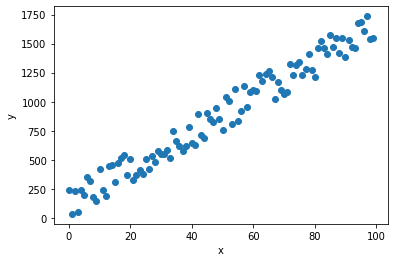

In [10]:
# Do not change the code in this cell
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    cost_sum = 0.0
    for x,y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    
    cost = cost_sum / (num_samples)
    
    return cost

### Q2.1 Implement Linear Regression using Batch Gradient Descent from scratch.  (15 points)


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

In [12]:
def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost and parameter array
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter])

    x = np.ones([num_samples, len(params)])
    for i in range(num_samples):
        x[i][1] = ip[i]
    
    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        params_store[:, iteration] = params
        
        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')


        
        # Apply batch gradient descent
        for i in range(0, num_samples):
            for j in range(len(params)):
                prevParams = params
                params[j] += (alpha / num_samples) * (op[i] - np.dot(prevParams, x[i])) * x[i][j]
        iteration += 1
    
    return params, cost, params_store

In [13]:
# Do not change the code in this cell
# Training the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-3
max_iter = 100
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)

--------------------------
iteration: 0
cost: 13402684.89272019
--------------------------
iteration: 1
cost: 25647.552486176028
--------------------------
iteration: 2
cost: 11494.891882920292
--------------------------
iteration: 3
cost: 11413.268490687566
--------------------------
iteration: 4
cost: 11409.950445088098
--------------------------
iteration: 5
cost: 11408.663329178691
--------------------------
iteration: 6
cost: 11407.437035803543
--------------------------
iteration: 7
cost: 11406.213137119677
--------------------------
iteration: 8
cost: 11404.989892323218
--------------------------
iteration: 9
cost: 11403.767249265296
--------------------------
iteration: 10
cost: 11402.545206107552
--------------------------
iteration: 11
cost: 11401.32376251068
--------------------------
iteration: 12
cost: 11400.102918180128
--------------------------
iteration: 13
cost: 11398.88267282289
--------------------------
iteration: 14
cost: 11397.663026146092
-----------------------

### Q2.2 Implement Stochastic Gradient Descent from scratch. (15 points)

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

In [14]:
# I changed input_var, output_var to ip, op as it was not taking the parameter values but taking the input_var and output_var (the whole data) defined in the earlier block.
def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    """
    Compute the params for linear regression using stochastic gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    Returns parameters, cost, params_store
    """

    # initialize iteration, number of samples, cost and parameter array
    num_samples = len(ip)
    cost = np.zeros(num_samples)
    params_store = np.zeros([2, num_samples])

    i = 0
    # Compute the cost and store the params for the corresponding cost
    for x, y in zip(ip, op):
        cost[i] = compute_cost(ip, op, params)
        params_store[:, i] = params

        print('--------------------------')
        print(f'iteration: {i}')
        print(f'cost: {cost[i]}')

        # Apply stochastic gradient descent
        X = [1.0, x]
        for j in range(len(params)):
            prevParams = params
            params[j] += (alpha / num_samples) * (y - np.dot(prevParams, X)) * X[j]
        i+=1

    return params, cost, params_store

In [15]:
# Do not change the code in this cell
alpha = 1e-3
params_0 = np.array([20.0, 80.0])
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)

--------------------------
iteration: 0
cost: 13402684.89272019
--------------------------
iteration: 1
cost: 12285020.778753806
--------------------------
iteration: 2
cost: 12123426.71300222
--------------------------
iteration: 3
cost: 10551039.695068264
--------------------------
iteration: 4
cost: 9750377.389334992
--------------------------
iteration: 5
cost: 9747900.959248804
--------------------------
iteration: 6
cost: 8007865.981455637
--------------------------
iteration: 7
cost: 7980064.2423681915
--------------------------
iteration: 8
cost: 6845169.750482736
--------------------------
iteration: 9
cost: 5252867.329937665
--------------------------
iteration: 10
cost: 5099129.674131528
--------------------------
iteration: 11
cost: 3882560.0659284727
--------------------------
iteration: 12
cost: 3445455.9905362627
--------------------------
iteration: 13
cost: 3092677.9816934867
--------------------------
iteration: 14
cost: 3031449.1229166174
--------------------------
i

### Q2.3 Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm (5 points)

In [18]:
# Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm
def calcRMSE(X, Y, params):
    """
    Calculates the Root mean square error.
    :param X: The input varaible of samples
    :param Y: The actual output variable of samples.
    :param params: The parameters of linears regression
    :return:
    """
    Y_cap = np.zeros(len(Y))
    for i in range(0, len(Y)):
        Y_cap[i] = np.dot(params, [1.0, X[i]])
    E = Y - Y_cap
    return np.sqrt(np.sum(E*E)/len(E))

print("Root Mean Square Error for Batch Gradient Descent: "+ str(calcRMSE(x_test, y_test, params_hat_batch)))
print("Root Mean Square Error for Stochastic Gradient Descent: "+ str(calcRMSE(x_test, y_test, params_hat)))


Root Mean Square Error for Batch Gradient Descent: 107.75738547600952
Root Mean Square Error for Stochastic Gradient Descent: 162.23990476697873


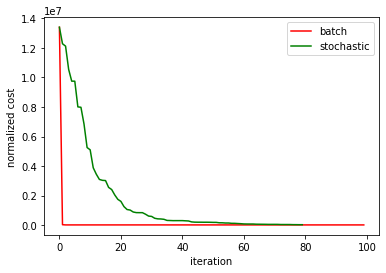

min cost with BGD: 11296.150524883096
min cost with SGD: 25350.89774939111


In [19]:
# Do not change the code in this cell
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

### Q2.4 Which linear regression model do you think works best for this data? Explain in brief. (5 points)

Based on how data is created, we have:
\begin{equation}
y = 15 x + 2.4 + 300.0 * uniform(0, 1)
\end{equation}
Thus, the model that works best for this data would be the one that provides the average results.
The expected value of $uniform(0, 1)$ is $0.5$. Thus we have:
\begin{equation}
\begin{split}
y &= 15 x + 2.4 + 300.0 * E(uniform(0, 1))\\
y &= 15 x + 2.4 + 300 * (0.5)\\
y &= 152.4 + 15x
\end{split}
\end{equation}

This will fit best with data and hence the best linear regression model.
Comparing it with $y = \theta_0 + \theta_1 x$, we have $\theta_0 = 152.4$ and $\theta_1 = 15$.

### Q3. Linear Regression Analytical Problem (10 points)
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.

We have:
\begin{equation}
X = \begin{bmatrix}
        1 & 0 & 0\\
        1 & 0 & 1\\
        1 & 1 & 0\\
        1 & 1 & 1
    \end{bmatrix}
\quad \text{and} \quad
Y = \begin{bmatrix}
        0\\
        1.5\\
        2\\
        2.5
    \end{bmatrix}
\end{equation}

Thus,
\begin{equation}
X^T = \begin{bmatrix}
        1 & 1 & 1 & 1\\
        0 & 0 & 1 & 1\\
        0 & 1 & 0 & 1
    \end{bmatrix}
\end{equation}

Hence,
\begin{equation}
X^TX = \begin{bmatrix}
        4 & 2 & 2\\
        2 & 2 & 1\\
        2 & 1 & 2
    \end{bmatrix}
\end{equation}
Now,
\begin{equation}
|X^TX| = 4(4-1) -2(4-2)+2(2-4)=4
\end{equation}
\begin{equation}
Cf(X^TX) = \begin{bmatrix}
        3 & -2 & -2\\
        -2 & 4 & 0\\
        -2 & 0 & 4
    \end{bmatrix}
\quad \text{and} \quad
Adj(X^TX) = (Cf(X^TX))^T = \begin{bmatrix}
        3 & -2 & -2\\
        -2 & 4 & 0\\
        -2 & 0 & 4
    \end{bmatrix}
\end{equation}
Thus,
\begin{equation}
(X^TX)^{-1} = \frac{1}{|X^TX|} Adj(X^TX)= \begin{bmatrix}
        0.75 & -0.5 & -0.5\\
        -0.5 & 1 & 0\\
        -0.5 & 0 & 1
    \end{bmatrix}
\end{equation}
Now,
\begin{equation}
(X^TX)^{-1}X^T = \begin{bmatrix}
        0.75 & 0.25 & 0.25 & -0.25\\
        -0.5 & -0.5 & 0.5 & 0.5\\
        -0.5 & 0.5 & -0.5 & 0.5
    \end{bmatrix}
\end{equation}

We have, $\theta^* = (X^TX)^{-1}X^TY$
Thus,
\begin{equation}
\theta^* = \begin{bmatrix}
        \theta_0\\
        \theta_1\\
        \theta_2
    \end{bmatrix}
    =\begin{bmatrix}
        0.25\\
        1.5\\
        1
    \end{bmatrix}
\end{equation}

Hence, the linear regression equation becomes:
\begin{equation}
y = 0.25 + 1.5X_1 + X_2
\end{equation}